## Determining the Drivers of Customer Recommendation

The goal of this project was to look at automotive customer survey data to determine why customers provide high ratings on their surveys, using the open ended comments. 

The open ended comments on these surveys have been sorted into topics on a sentence-by-sentence basis, using proprietary text analysis software. A survey can have multiple topics attributed to it, due to the fact that customers can type at length about their experience and touch on many different topics (e.g. friendliness, professionalism, timeliness, etc.).

The rating scale question analyzed was a 0-10 scale question asking "How likely are you to recommend this dealership to a friend or family member?" with 0 being very unlikely and 10 being very likely. 

Using logistic regression, the specific goal was to measure the ability of each topic to predict a score over a certain threshhold, and then to rank those topics. The topics have been given generic names to protect intellectual property.

Data is made up of ~79k dealer service surveys from a major automotive OEM received between October and December 2015, which contained comments hitting one or more of the 200 most frequently hit topics (out of an available 756 topics).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from itertools import product

#### Read in the survey data and prep the data for logistic regression. 
In many cases there is more than one record per response_id (individual survey) - this is because a customer's comments may be sorted into more than one topic. The data at first is one row per topic - the data preparation will result in one row per survey, with columns for each possible topic.

In [2]:
df = pd.read_csv('capstone1.4.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254421 entries, 0 to 254420
Data columns (total 3 columns):
response_id                 254421 non-null int64
topic                       254421 non-null object
nps_dealer_service_score    254421 non-null int64
dtypes: int64(2), object(1)
memory usage: 5.8+ MB


In [3]:
df.head()

,response_id,topic,nps_dealer_service_score
0,108239411,topic_123,9
1,108239411,topic_156,9
2,108245208,topic_166,1
3,108252982,topic_46,8
4,108252982,topic_92,8


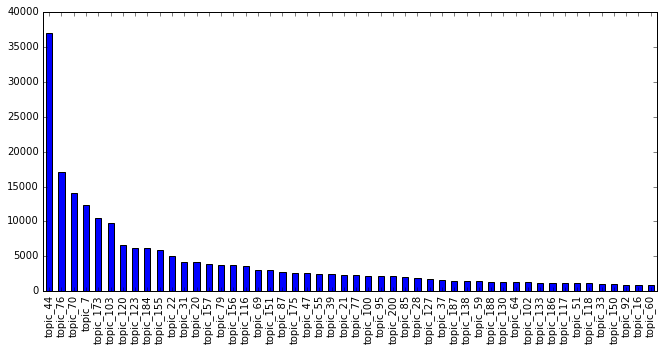

In [4]:
df.topic.value_counts()[:50].plot(kind='bar',figsize=(11,5))

In [5]:
nps_scores = df[['response_id','nps_dealer_service_score']].drop_duplicates().set_index('response_id')

In [6]:
topic_table = (
            df
            .groupby('response_id')
            .topic
            .value_counts()
            .reset_index()
            .pivot(index='response_id',columns='topic',values=0)
            .fillna(0)
            .assign(scores = nps_scores)
            .dropna()
)

In [7]:
topic_table.head()

topic,topic_1,topic_10,topic_100,topic_101,topic_102,topic_103,topic_104,topic_105,topic_106,topic_107,...,topic_91,topic_92,topic_93,topic_94,topic_95,topic_96,topic_97,topic_98,topic_99,scores
response_id,,,,,,,,,,,,,,,,,,,,,
108239411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
108245208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
108252982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8
108262111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10
108264917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


#### Run the analysis, adapting target scores, number of topics and decision threshhold, to determine optimal performance as measured by F1 Score.

In [8]:
def metric_cube():
    results = []
    scores = range(5,10)
    topics = range(30,51)
    threshholds = np.arange(0.1,1.0,0.1)
    for score, top_topics, threshhold in product(scores, topics, threshholds):
        metric = logistic_regression(topic_table, score, top_topics, threshhold)
        results.append((metric, score, top_topics, threshhold))
    results.sort(key = lambda x: x[0])
    print(results[-1])
    
    
def logistic_regression(sample, score, top_topics, threshhold):
       
    sample['promoter'] = (sample.scores > score).astype(int)
    
    cols = df.topic.value_counts().head(top_topics).index
    model = smf.logit('promoter ~ {}'.format(' + '.join(cols)), sample).fit()
    
    probabilities = model.predict(sample)
    decisions = (probabilities > threshhold).astype(int)
    
    f1 = f1_score(sample.promoter, decisions)
    return f1

metric_cube()

Optimization terminated successfully.
         Current function value: 0.321816
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.321816
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.321816
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.321816
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.321816
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.321816
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.321816
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.321816
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.321816
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.321766
  

#### The results of this analysis show that one can expect an optimal F1 score of 93 if one looks for scores above 5, uses 50 predictor variables (topics), and uses 0.5 as the decision threshhold.

#### Rerun the logistic regression using these parameters, displaying the summary and other metrics including a confusion matrix.

In [9]:
def optimal_logistic_regression(score, top_topics, threshhold):

    topic_table['promoter'] = (topic_table.scores > score).astype(int)
    
    cols = df.topic.value_counts().head(top_topics).index
    model = smf.logit('promoter ~ {}'.format(' + '.join(cols)), topic_table).fit()
    print(model.summary())
    
    probabilities = model.predict(topic_table)
    decisions = (probabilities > threshhold).astype(int)
    
    accuracy = accuracy_score(topic_table.promoter, decisions)
    print('\nAccuracy Score: {}'.format(accuracy))
    
    recall = recall_score(topic_table.promoter, decisions)
    print('\nRecall Score: {}'.format(recall))
    
    precision = precision_score(topic_table.promoter, decisions)
    print('\nPrecision Score: {}'.format(precision))
    
    f1 = f1_score(topic_table.promoter, decisions)
    print('\nF1 Score: {}'.format(f1))
    
    cm = confusion_matrix(topic_table.promoter, decisions)
    print('\nConfusion Matrix:\n')
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    tick_marks = np.arange(2)
    plt.xticks(tick_marks)
    plt.yticks(tick_marks)
    plt.ylabel('true')
    plt.xlabel('predicted')
    
    return model

Optimization terminated successfully.
         Current function value: 0.314825
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               promoter   No. Observations:                78739
Model:                          Logit   Df Residuals:                    78688
Method:                           MLE   Df Model:                           50
Date:                Tue, 31 May 2016   Pseudo R-squ.:                  0.2011
Time:                        13:22:29   Log-Likelihood:                -24789.
converged:                       True   LL-Null:                       -31030.
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.5313      0.018     83.974      0.000         1.496     1.567
topic_44       1.2421      0.

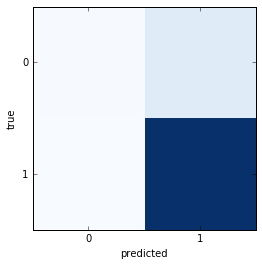

In [10]:
optimal_model = optimal_logistic_regression(5, 50, 0.5)

#### Sort the top 20 topics by coefficient to arrive at the top drivers of customer recommendation.

In [11]:
optimal_model.params.sort_values(ascending=False)[1:21]

topic_44     1.242115
topic_21     1.181158
topic_123    0.933333
topic_70     0.889318
topic_173    0.863917
topic_188    0.813581
topic_64     0.765652
topic_133    0.762476
topic_47     0.579066
topic_120    0.573956
topic_76     0.552654
topic_79     0.410079
topic_130    0.397736
topic_7      0.322238
topic_87     0.299379
topic_60     0.220651
topic_118    0.216701
topic_22     0.207159
topic_39     0.138712
topic_16     0.115550
dtype: float64